In [ ]:
import os, time, sys

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import gridspec
import matplotlib.ticker as mtick
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

import pcms.haar
import pcms.tree
import kspt
import utils

In [ ]:
DATA = os.environ['DATA']
GN_DATA = os.path.join(DATA, 'guerrero_negro')
GG_DATA = os.path.join(DATA, 'greengenes/gg_13_8_otus')
GG_TREES = os.path.join(GG_DATA, 'trees')
GG_OTU_MAPS = os.path.join(GG_DATA, 'otus')

### Load 97% Greengenes tree

In [ ]:
tree = pcms.tree.nwk2tree(os.path.join(GG_TREES, '97_otus.nwk'), ensure_planted=True)
n_leaves = tree.find_n_leaves()
seq_id2leaf_idx = utils.build_gg_seq_id2leaf_idx_map(tree)

In [ ]:
interior_nodes = tree.find_interior_nodes()
tax_filepath = os.path.join(GG_DATA, 'taxonomy/97_otu_taxonomy.txt')

In [ ]:
edge_lengths = tree.get_edge_length()
min_edge_length = np.min(edge_lengths[edge_lengths != 0])
print(f"Enforced minimum edge lenght: {min_edge_length}")

for node in range(tree.n_nodes):
    tree.set_edge_length(node, max(min_edge_length, tree.get_edge_length(node)))

Enforced minimum edge lenght: 0.0001


### Edge length distribution

In [ ]:
edge_lengths = tree.get_edge_length()
subtree_sizes = tree.get_subtree_size()

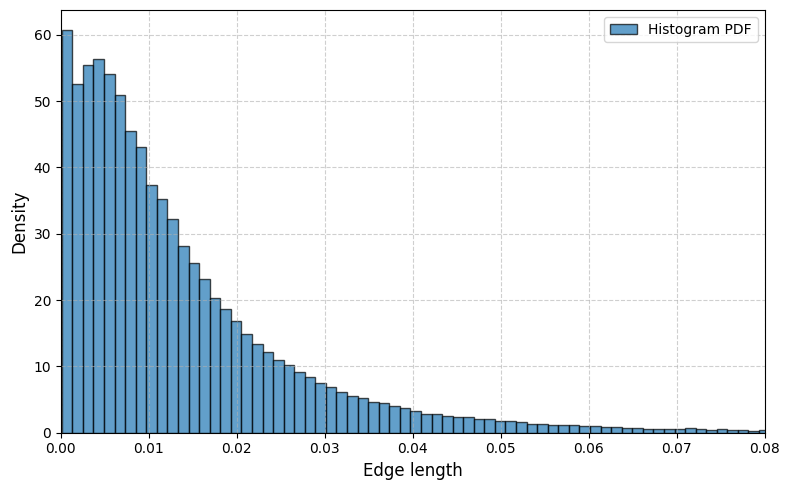

In [ ]:
# Histogram
n_bins = int(np.sqrt(tree.n_nodes))
pdf_values, bins = np.histogram(edge_lengths, bins=n_bins, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_widths = bins[1:] - bins[:-1]

xmax = 0.08

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(bin_centers, pdf_values, width=bin_widths, color='C0', edgecolor='black', alpha=0.7, label='Histogram PDF')
ax.set_xlim(0, xmax)
ax.set_ylim(bottom=0)
ax.set_xlabel('Edge length', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.grid(visible=True, linestyle='--', alpha=0.6)
ax.legend()
fig.tight_layout()
plt.show()

##### Helper function

In [ ]:
def make_hist(ax, data, title, xlabel, color, cdf=False, discrete=False):
    n_bins = int(np.sqrt(len(data)))
    pdf_values, bins = np.histogram(data, bins=n_bins, density=True)
    if discrete or cdf:
        pdf_values /= pdf_values.sum()
    bin_widths = bins[:-1] - bins[1:]

    if cdf:
        ax.bar(bins[1:], pdf_values.cumsum(), width=bin_widths,
               color=color, edgecolor='black', alpha=0.7, label='PDF')
    else:
        ax.bar(bins[1:], pdf_values, width=bin_widths,
               color=color, edgecolor='black', alpha=0.7, label='PDF')
    ax.set_xlim(0, 0.08)
    ax.set_ylim(bottom=0)
    ax.set_xlabel(xlabel, fontsize=12)
    if cdf:
        ax.set_ylabel('Cumulative Density', fontsize=12)
    else:
        ax.set_ylabel('Density', fontsize=12)
    ax.set_title(title, fontsize=13)
    ax.grid(visible=True, linestyle='--', alpha=0.6)

##### Copula Function

In [ ]:
K = 25

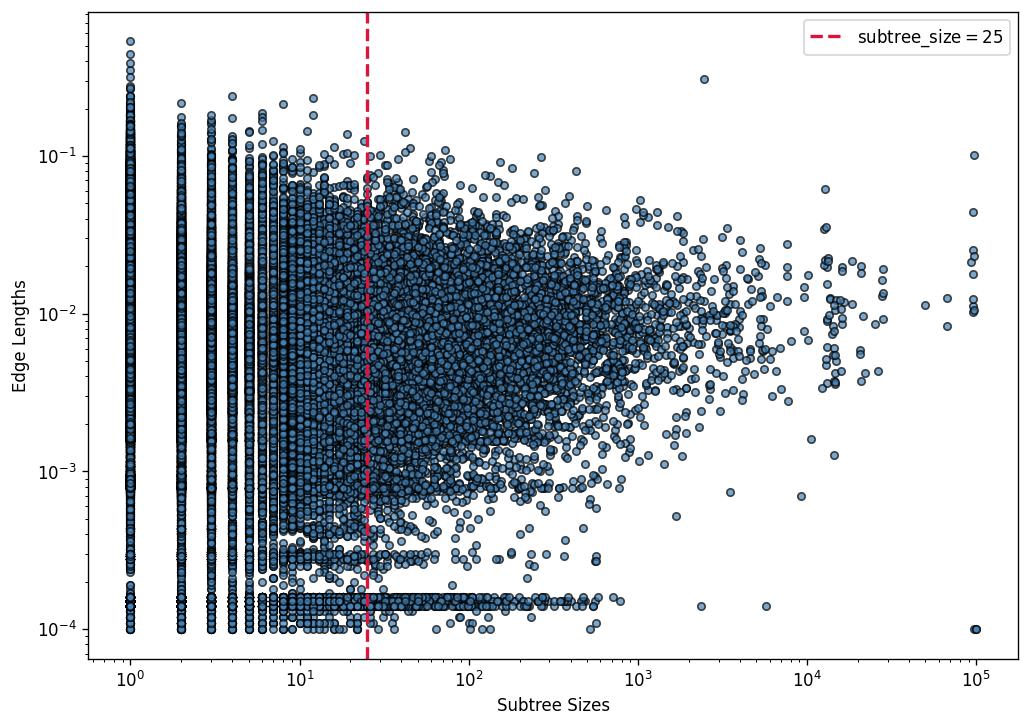

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7), dpi=120)
ax.scatter(subtree_sizes, edge_lengths, 
           s=20, color="steelblue", alpha=0.7, edgecolor="k")

ax.set_xscale('log')
ax.set_yscale('log')

ax.axvline(K, color="crimson", linestyle="--", lw=2, label=r"$\mathrm{subtree\_size} = $" + f"{K}")

# labels and legend
ax.set_xlabel("Subtree Sizes")
ax.set_ylabel("Edge Lengths")
ax.legend()

plt.show()

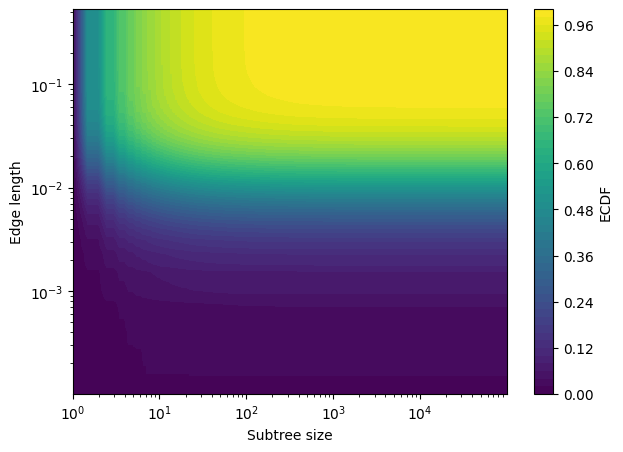

In [ ]:
N = 5000

X = subtree_sizes
Y = edge_lengths

# Use bin edges, not centers
x_edges = np.logspace(np.log10(X.min()), np.log10(X.max()), N + 1).astype(int)
y_edges = np.logspace(np.log10(Y.min()), np.log10(Y.max()), N + 1)

# Find bin indices for each point
u_idx = np.searchsorted(x_edges, X, side='right') - 1
v_idx = np.searchsorted(y_edges, Y, side='right') - 1

# Clip indices to valid range
u_idx = np.clip(u_idx, 0, N-1)
v_idx = np.clip(v_idx, 0, N-1)

# Count occurrences in each bin
F = np.zeros((N, N))
np.add.at(F, (u_idx, v_idx), 1)

# Compute cumulative sum along both axes to get ECDF
F = np.cumsum(np.cumsum(F, axis=0), axis=1)
F = F / X.size

# Bin centers for plotting
Xs = (x_edges[:-1] + x_edges[1:]) / 2
Ys = (y_edges[:-1] + y_edges[1:]) / 2
Xv, Yv = np.meshgrid(Xs, Ys, indexing='ij')

# Plot
plt.figure(figsize=(7,5))
plt.contourf(Xv, Yv, F, levels=50, cmap='viridis')
plt.colorbar(label='ECDF')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Subtree size')
plt.ylabel('Edge length')
plt.show()

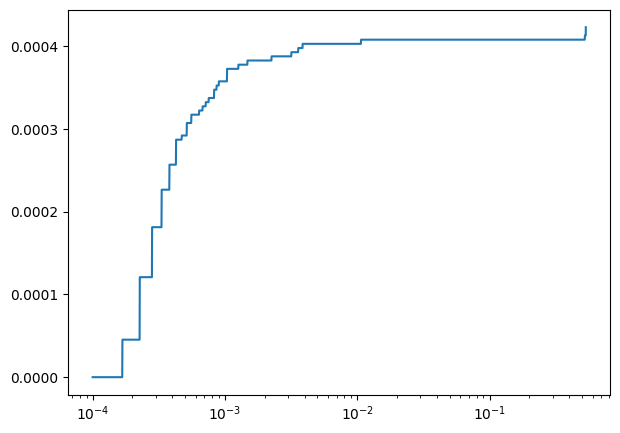

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(Ys, F[:,K])
plt.xscale("log")
plt.show()

/tmp/ipykernel_10003/2249382952.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


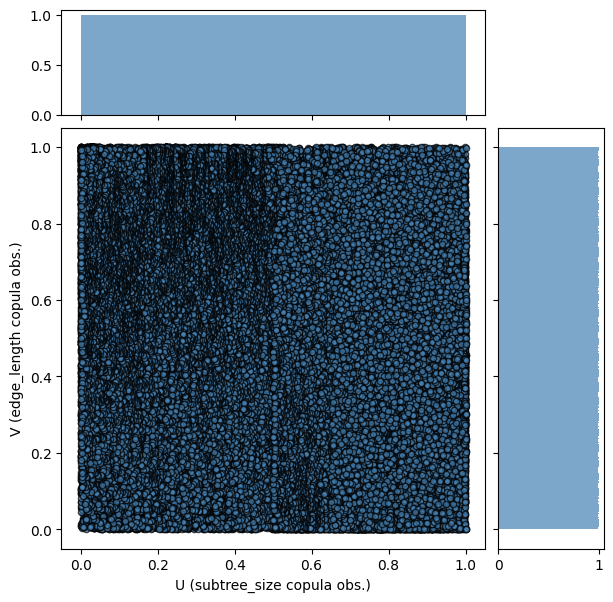

In [ ]:
N = 1000

def copula_transform(X):
    ranks = np.argsort(np.argsort(X)) + 1
    return ranks / len(X)

U = copula_transform(edge_lengths)
V = copula_transform(subtree_sizes)

fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                       wspace=0.05, hspace=0.05)

ax_scatter = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_scatter)

# Scatter
ax_scatter.scatter(V, U,
                   s=20, color="steelblue", alpha=0.7, edgecolor="k")

# Marginal histograms
ax_histx.hist(V, bins=N, color="steelblue", alpha=0.7,
              density=True)
ax_histy.hist(U, bins=N, orientation='horizontal',
              color="steelblue", alpha=0.7, density=True)

# Remove tick labels for the histograms
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)

ax_scatter.set_xlabel("U (subtree_size copula obs.)")
ax_scatter.set_ylabel("V (edge_length copula obs.)")

plt.tight_layout()
plt.show()

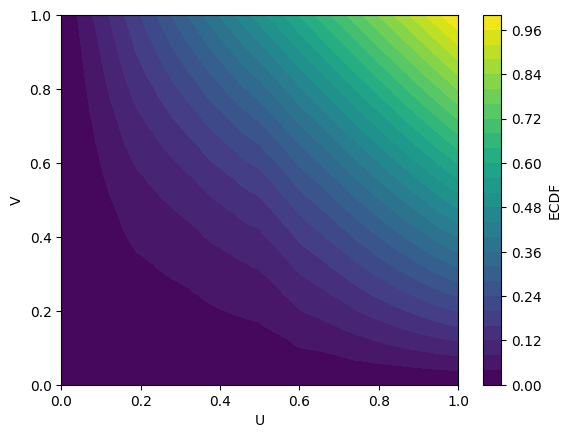

In [ ]:
N = 1000

xs = np.linspace(0, 1, N)
xv, yv = np.meshgrid(xs, xs)

u_idx = np.searchsorted(xs, U, side='right') - 1
v_idx = np.searchsorted(xs, V, side='right') - 1

C = np.zeros((N, N), dtype=int)
np.add.at(C, (u_idx, v_idx), 1)

C = np.cumsum(np.cumsum(C, axis=0), axis=1)
C = C / len(U)

plt.contourf(xs, xs, C, levels=25, cmap='viridis')
plt.colorbar(label='ECDF')
plt.xlabel('U')
plt.ylabel('V')
plt.show()

##### Is there a change in distribution over the total sequence?

In [ ]:
indxs_subtree_size = np.argsort(subtree_sizes)

In [ ]:
start_time = time.time()
T_obs_total, Ts_total, F_obs_total = kspt.max_split_ks_perm_test(edge_lengths[indxs_subtree_size])
print("Elapsed time: ", time.time() - start_time)

Elapsed time:  301.02275371551514


In [ ]:
print(f"T_obs: {T_obs_total:0.5e}, p: {1-F_obs_total:0.5e}")

T_obs: 3.80810e-01, p: 0.00000e+00


In [ ]:
left = edge_lengths[indxs_subtree_size][:edge_lengths.size//2]
right = edge_lengths[indxs_subtree_size][edge_lengths.size//2:]

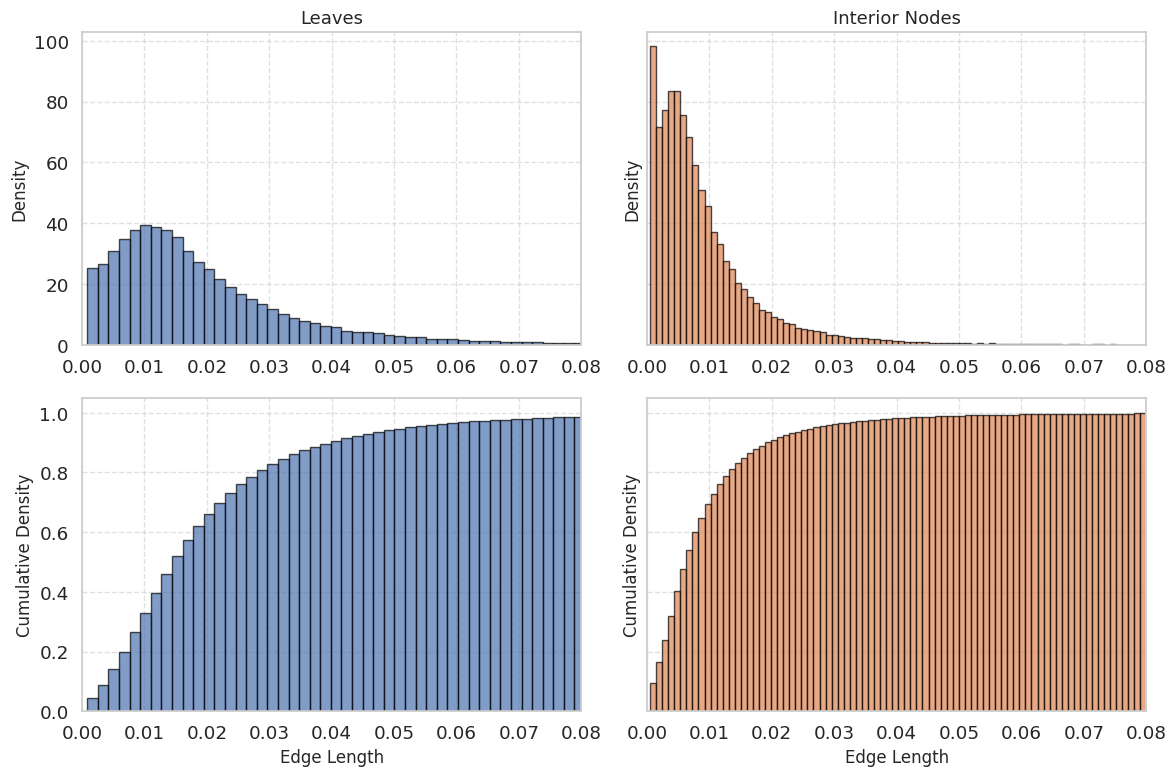

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey='row')

make_hist(axes[0][1], right, "Interior Nodes", "", "C1")
make_hist(axes[0][0], left, "Leaves", "", "C0")
make_hist(axes[1][1], right, "", "Edge Length", "C1", cdf=True)
make_hist(axes[1][0], left, "", "Edge Length", "C0", cdf=True)

fig.tight_layout()
plt.show()

##### Is there a change in distribution over the interior nodes?

In [ ]:
start_time = time.time()
T_obs_right, Ts_right, F_obs_right = kspt.max_split_ks_perm_test(right)
print("Elapsed time: ", time.time() - start_time)

Elapsed time:  117.85094738006592


In [ ]:
print(f"T_obs: {T_obs_right:0.5e}, p: {1-F_obs_right:0.5e}")

T_obs: 9.41020e-02, p: 0.00000e+00


In [ ]:
vals, counts = np.unique(subtree_sizes[indxs_subtree_size][tree.n_nodes//2:], return_counts=True)

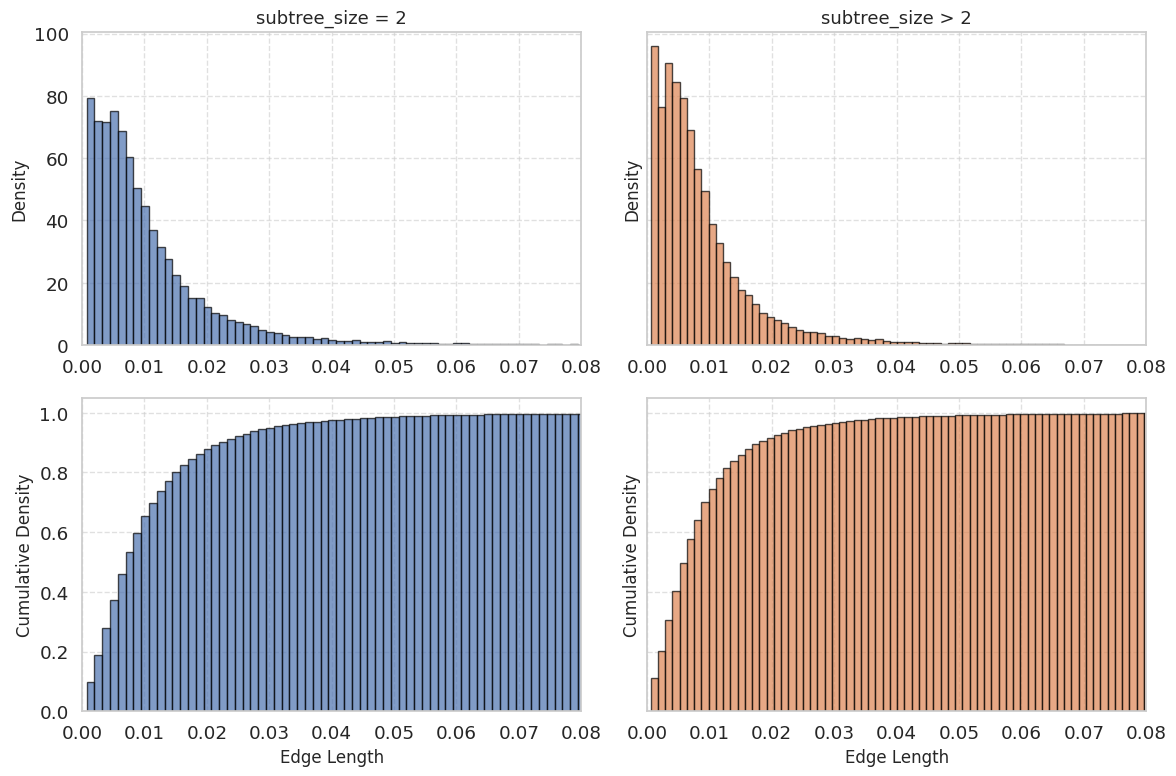

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey='row')

make_hist(axes[0][1], right[counts[0]:], "subtree_size > 2", "", "C1")
make_hist(axes[0][0], right[:counts[0]], "subtree_size = 2", "", "C0")
make_hist(axes[1][1], right[counts[0]:], "", "Edge Length", "C1", cdf=True)
make_hist(axes[1][0], right[:counts[0]], "", "Edge Length", "C0", cdf=True)

fig.tight_layout()
plt.show()

In [ ]:
counts

array([29967, 14968,  9140, ...,     1,     1,     2], shape=(1171,))

In [ ]:
start_time = time.time()
T_obs_right3, Ts_right3, F_obs_right3 = kspt.max_split_ks_perm_test(right[counts[0]:])
print("Elapsed time: ", time.time() - start_time)

Elapsed time:  72.2391951084137


In [ ]:
print(f"T_obs: {T_obs_right3:0.5e}, p: {1-F_obs_right3:0.5e}")

T_obs: 7.10796e-02, p: 0.00000e+00


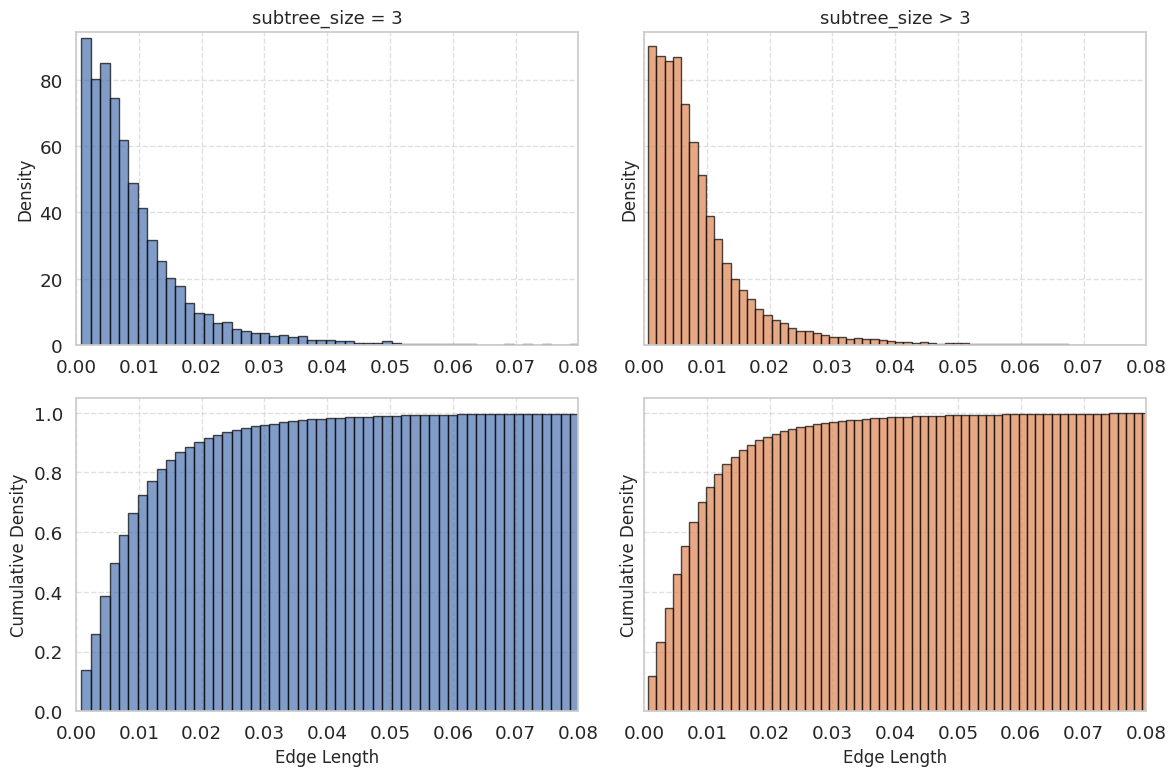

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey='row')

make_hist(axes[0][1], right[counts[0]+counts[1]:], "subtree_size > 3", "", "C1")
make_hist(axes[0][0], right[counts[0]:counts[0]+counts[1]], "subtree_size = 3", "", "C0")
make_hist(axes[1][1], right[counts[0]+counts[1]:], "", "Edge Length", "C1", cdf=True)
make_hist(axes[1][0], right[counts[0]:counts[0]+counts[1]], "", "Edge Length", "C0", cdf=True)

fig.tight_layout()
plt.show()

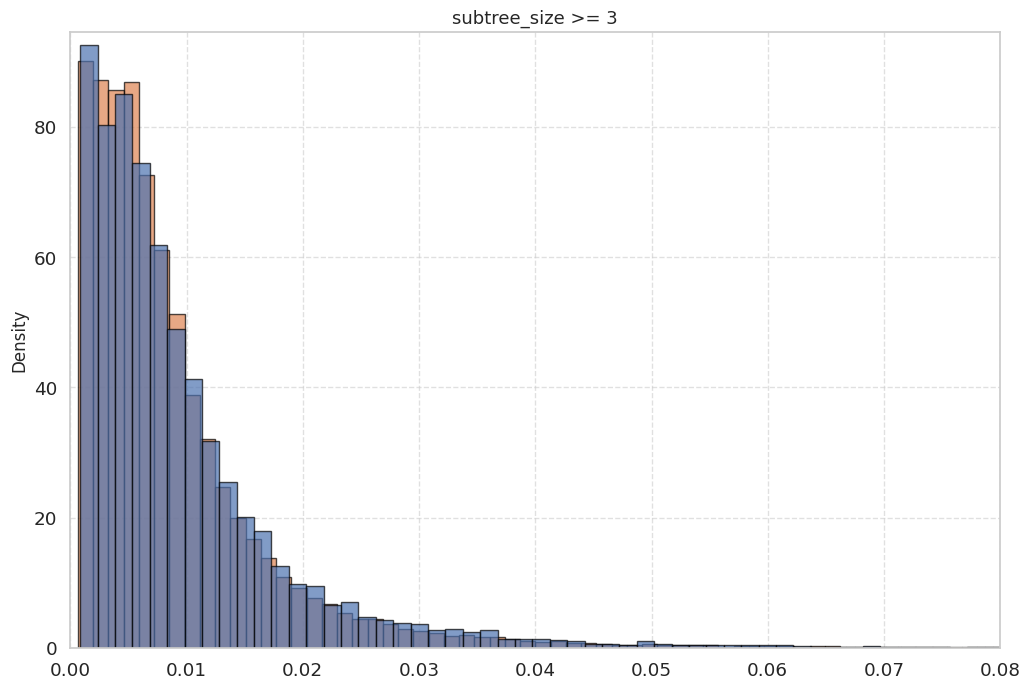

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(12, 8), sharey='row')

make_hist(axes, right[counts[0]+counts[1]:], "subtree_size >= 3", "", "C1")
make_hist(axes, right[counts[0]:counts[0]+counts[1]], "subtree_size >= 3", "", "C0")

##### Is child edge length correlated with parent edge length?

In [ ]:
avg_child_edge_lengths = []
interior_nodes = tree.find_interior_nodes()
for i in interior_nodes:
    children = tree.find_children(i)
    child_lengths = [edge_lengths[c] for c in children]
    avg_child_edge_lengths.append(np.mean(child_lengths))
avg_child_edge_lengths = np.asarray(avg_child_edge_lengths)

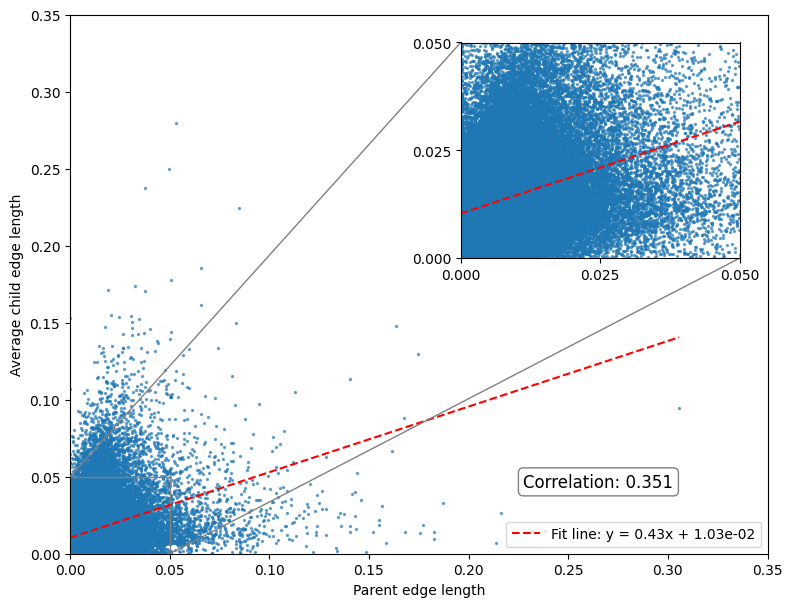

In [ ]:
fig, ax = plt.subplots(figsize=(9,7))

# Compute correlation coefficient
corr = np.corrcoef(avg_child_edge_lengths, edge_lengths[interior_nodes])[0, 1]

# Linear regression parameters (y = m*x + b)
m, b = np.polyfit(edge_lengths[interior_nodes], avg_child_edge_lengths, 1)

# Scatter plot full range
ax.scatter(edge_lengths[interior_nodes], avg_child_edge_lengths, s=2, alpha=0.6)
ax.set_xlabel("Parent edge length")
ax.set_ylabel("Average child edge length")

# Plot the best fit line on full range
x_vals = np.array([edge_lengths[interior_nodes].min(), edge_lengths[interior_nodes].max()])
y_vals = m * x_vals + b
ax.plot(x_vals, y_vals, 'r--', label=f"Fit line: y = {m:.2f}x + {b:.2e}")

ax.set_xlim(edge_lengths[interior_nodes].min(), 0.35)
ax.set_ylim(avg_child_edge_lengths.min(), 0.35)

# Add correlation coefficient text
ax.text(0.65, 0.15, f"Correlation: {corr:.3f}", transform=ax.transAxes,
        fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray"))

# Create inset axes for zoomed plot
axins = inset_axes(ax, width="40%", height="40%", loc='upper right', borderpad=2)

# Scatter zoomed in
axins.scatter(edge_lengths[interior_nodes], avg_child_edge_lengths, s=2, alpha=0.6)

# Zoomed best fit line (same slope/intercept)
x_zoom = np.array([0, 0.05])
y_zoom = m * x_zoom + b
axins.plot(x_zoom, y_zoom, 'r--')

axins.set_xlim(0, 0.05)
axins.set_ylim(0, 0.05)
axins.set_xticks([0, 0.025, 0.05])
axins.set_yticks([0, 0.025, 0.05])

# Draw rectangle on main plot showing zoom region
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

ax.legend(loc='lower right')
plt.show()

##### Is trace length determined more by edge length or topology?

In [ ]:
tmp_tree = pcms.tree.nwk2tree(os.path.join(GG_TREES, '97_otus.nwk'), ensure_planted=True)

In [ ]:
edge_lengths = tmp_tree.get_edge_length()
eps = np.min(edge_lengths[edge_lengths != 0])
print(f"Enforced minimum edge lenght: {eps}")

for node in range(tmp_tree.n_nodes):
    if tmp_tree.get_edge_length(node) == 0:
        tmp_tree.set_edge_length(node, eps)

Enforced minimum edge lenght: 0.0001


In [ ]:
subtree_sizes = tmp_tree.get_subtree_size()

In [ ]:
Q, S = pcms.haar.sparsify(tmp_tree)

In [ ]:
diag = S.diagonal()
N = 1000
sort_idxs = np.argsort(diag)[::-1]

In [ ]:
intr_nodes, intr_depths = tmp_tree.find_interior_nodes(return_depths=True)
leaves = tmp_tree.find_leaves()
subsets = [intr_nodes, leaves]

for subset in subsets:
    perm = np.random.permutation(subset.size)
    for i, node in enumerate(subset):
        tmp_tree.set_edge_length(node, edge_lengths[subset[perm[i]]])

_, S_perm = pcms.haar.sparsify(tmp_tree)
diag_perms = S_perm.diagonal()

In [ ]:
new_sort_idxs = np.argsort(diag_perms)[::-1]

In [ ]:
x = diag
y = diag_perms

mask = (x > 0) & (y > 0)
m, b = np.polyfit(np.log(x[mask]), np.log(y[mask]), 1)

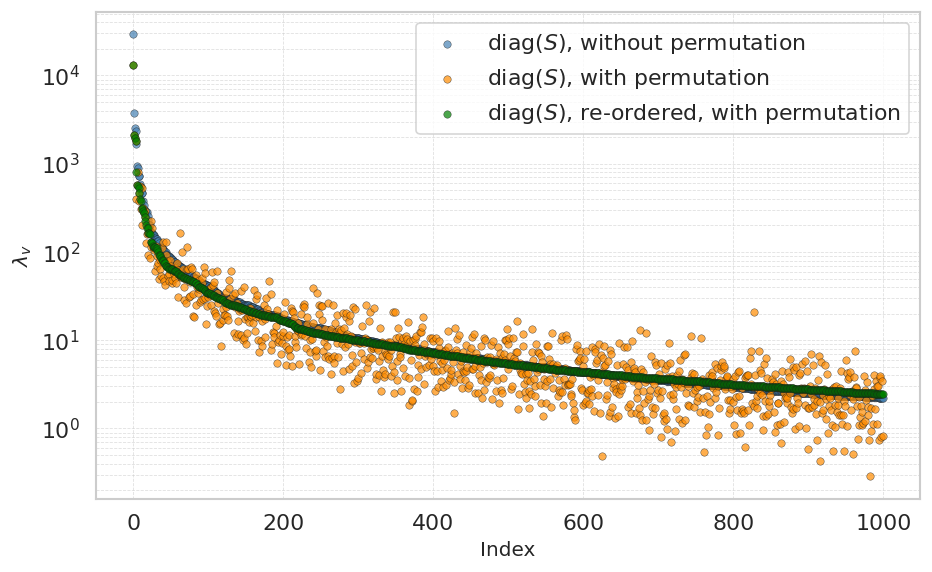

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=120)

x = np.arange(N)

# scatter points for the original diag
ax.scatter(
    x, diag[sort_idxs[:N]],
    s=20,
    color="steelblue",
    alpha=0.7,
    edgecolor="k", 
    linewidth=0.3,
    label=r'$\mathrm{diag}(S)$, without permutation'
)
ax.scatter(
    x, diag_perms[sort_idxs[:N]],
    s=20,
    color="darkorange",
    alpha=0.7,
    edgecolor="k", 
    linewidth=0.3,
    label=r'$\mathrm{diag}(S)$, with permutation'
)
ax.scatter(
    x, diag_perms[new_sort_idxs[:N]],
    s=20,
    color="green",
    alpha=0.7,
    edgecolor="k", 
    linewidth=0.3,
    label=r'$\mathrm{diag}(S)$, re-ordered, with permutation'
)

# log scale for y
ax.set_yscale('log')

# labels and title
ax.set_xlabel("Index", fontsize=12)
ax.set_ylabel(r"$\lambda_v$", fontsize=12)

# grid and legend
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

Points inside box: 793/1000 (79.30%)


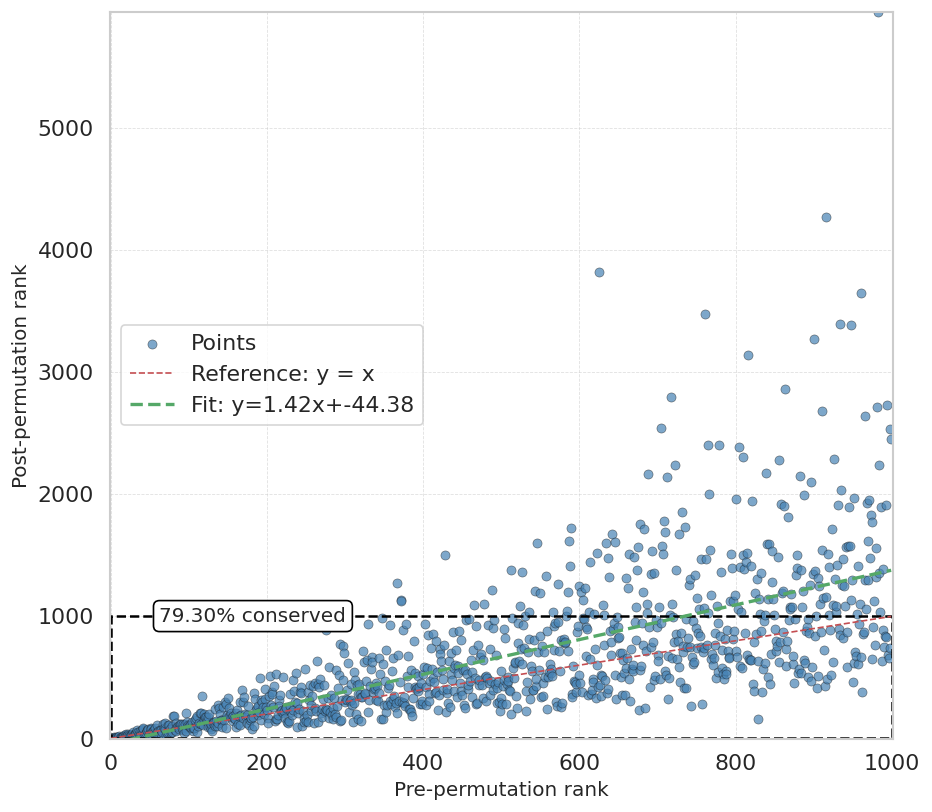

In [ ]:
new_rank_map = {item: rank for rank, item in enumerate(new_sort_idxs)}

old_ranks = np.arange(sort_idxs.size)
new_ranks = np.array([new_rank_map[sort_idxs[i]] for i in old_ranks])

# Take first N points
x = old_ranks[:N]
y = new_ranks[:N]

# Count points inside [0,N] x [0,N]
inside_mask = (x >= 0) & (x <= N) & (y >= 0) & (y <= N)
count_inside = np.sum(inside_mask)
percentage = (count_inside / N) * 100
print(f"Points inside box: {count_inside}/{N} ({percentage:.2f}%)")

# Linear fit
slope, intercept = np.polyfit(x, y, 1)
fit_y = slope * x + intercept

# Plot
fig, ax = plt.subplots(figsize=(8, 7), dpi=120)

# Scatter points
ax.scatter(
    x, y,
    s=30,
    color="steelblue",
    alpha=0.7,
    edgecolor="k",
    linewidth=0.3,
    label="Points"
)

# Diagonal reference
ax.plot([0, N-1], [0, N-1], 'r--', lw=1, label="Reference: y = x")

# Linear fit line
ax.plot(x, fit_y, 'g--', lw=2, label=f"Fit: y={slope:.2f}x+{intercept:.2f}")

# Draw the box [0,N] x [0,N]
ax.add_patch(plt.Rectangle((0, 0), N, N, 
                           fill=False, color="black", lw=1.5, linestyle="--"))

# Percentage text box
ax.text(
    N/16, N+2,
    f"{percentage:.2f}% conserved",
    fontsize=12,
    va="center", ha="left",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3")
)

ax.set_xlim(-1, max(N+1, x.max()+1))
ax.set_ylim(-1, max(N+1, y.max()+1))

ax.set_xlabel("Pre-permutation rank", fontsize=12)
ax.set_ylabel("Post-permutation rank", fontsize=12)

ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)
ax.legend(loc='center left')

plt.tight_layout()
plt.show()

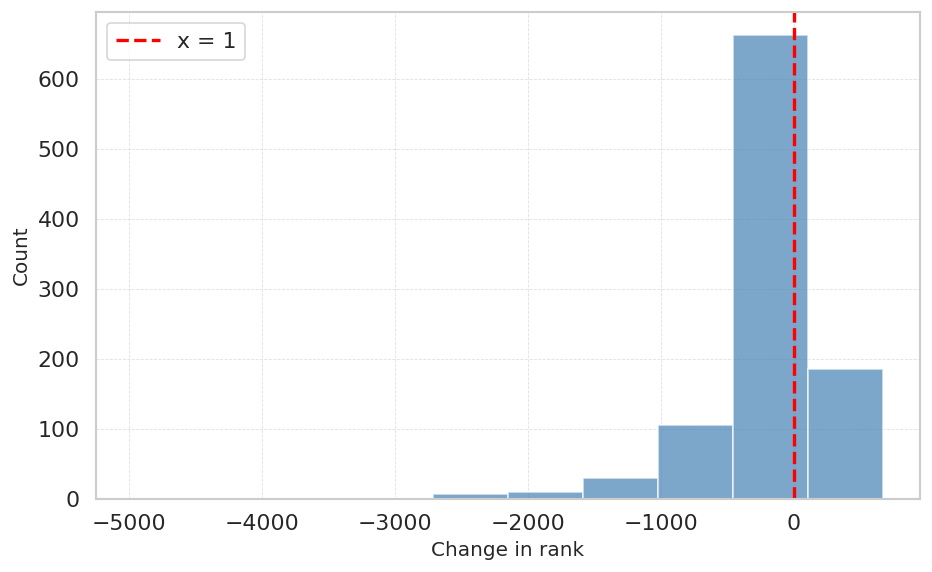

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=120)

x = old_ranks[:N]
y = new_ranks[:N]

changes = x - y

# histogram with log-spaced bins
ax.hist(
    changes,
    color="steelblue",
    alpha=0.7,
    edgecolor="white",
    linewidth=1
)

# vertical reference line at 1
ax.axvline(x=1, color='red', linestyle='--', linewidth=2, label='x = 1')

# labels and title
ax.set_xlabel(r"Change in rank", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

# grid and legend
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)
ax.legend()

plt.tight_layout()
plt.show()

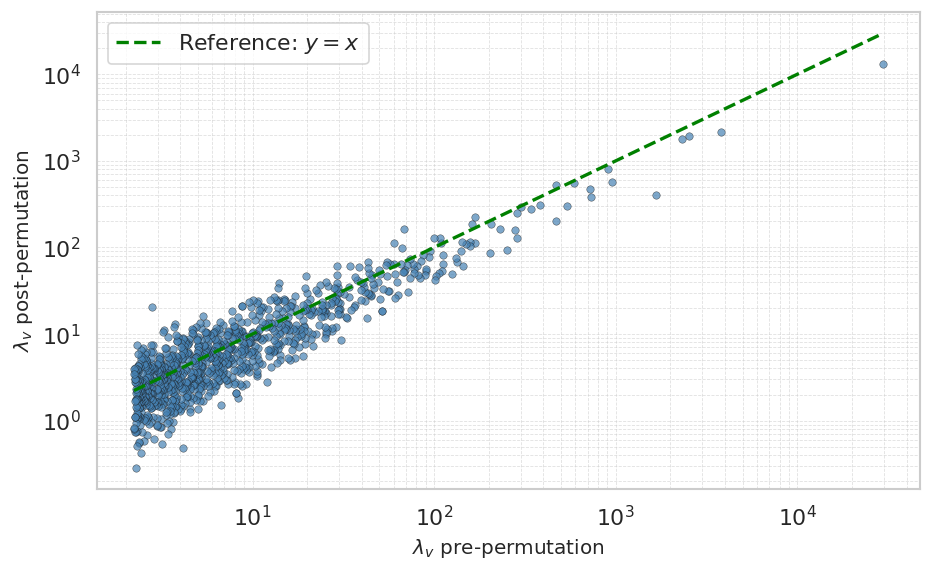

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=120)

x = diag[sort_idxs[:N]]
y = diag_perms[sort_idxs[:N]]

# scatter points
ax.scatter(
    x, y,
    s=20,
    color="steelblue",
    alpha=0.7,
    edgecolor="k", 
    linewidth=0.3
)

xx = np.logspace(np.log10(x[mask[sort_idxs[:N]]].min()), np.log10(x[mask[sort_idxs[:N]]].max()), 200)

ax.plot(
    xx, xx, 
    color="green", 
    lw=2, 
    linestyle='--',
    label=fr"Reference: $y = x$"
)

# log scales
ax.set_yscale('log')
ax.set_xscale('log')

# labels and title
ax.set_xlabel(r"$\lambda_v$ pre-permutation", fontsize=12)
ax.set_ylabel(r"$\lambda_v$ post-permutation", fontsize=12)

# legend & grid
ax.legend()
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)

plt.tight_layout()
plt.show()

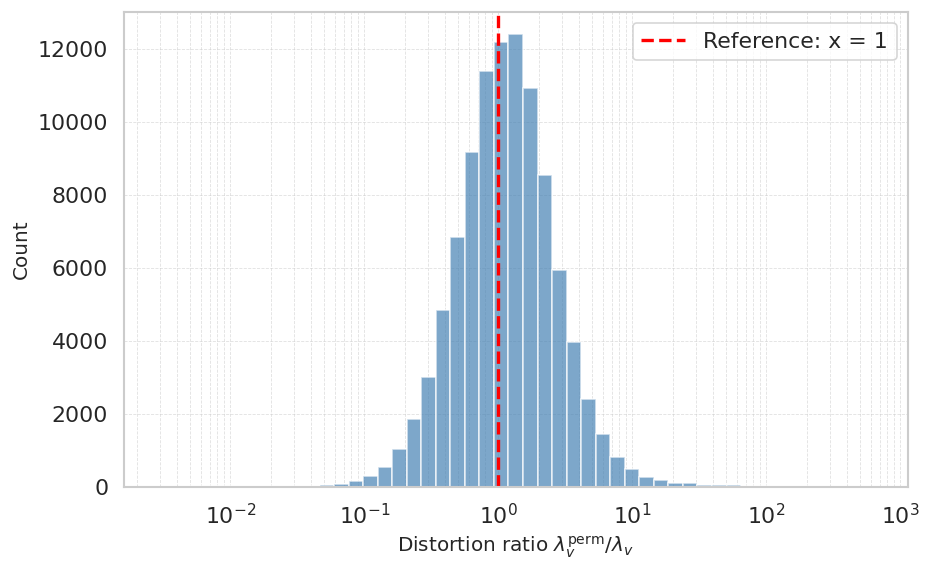

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=120)

# flatten all permutations
x = diag        
y = diag_perms

# compute distortion ratio for all M*N values
distortion_ratio = (y / x)

# define log-spaced bins
bins = np.logspace(np.log10(distortion_ratio.min()), np.log10(distortion_ratio.max()), 50)

# histogram with log-spaced bins
ax.hist(
    distortion_ratio,
    bins=bins,
    color="steelblue",
    alpha=0.7,
    edgecolor="white",
    linewidth=1
)

# vertical reference line at 1
ax.axvline(x=1, color='red', linestyle='--', linewidth=2, label='Reference: x = 1')

# log scale on x-axis
ax.set_xscale('log')

# labels and title
ax.set_xlabel(r"Distortion ratio $\lambda_v^\mathrm{perm} / \lambda_v$", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

# grid and legend
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)
ax.legend()

plt.tight_layout()
plt.show()

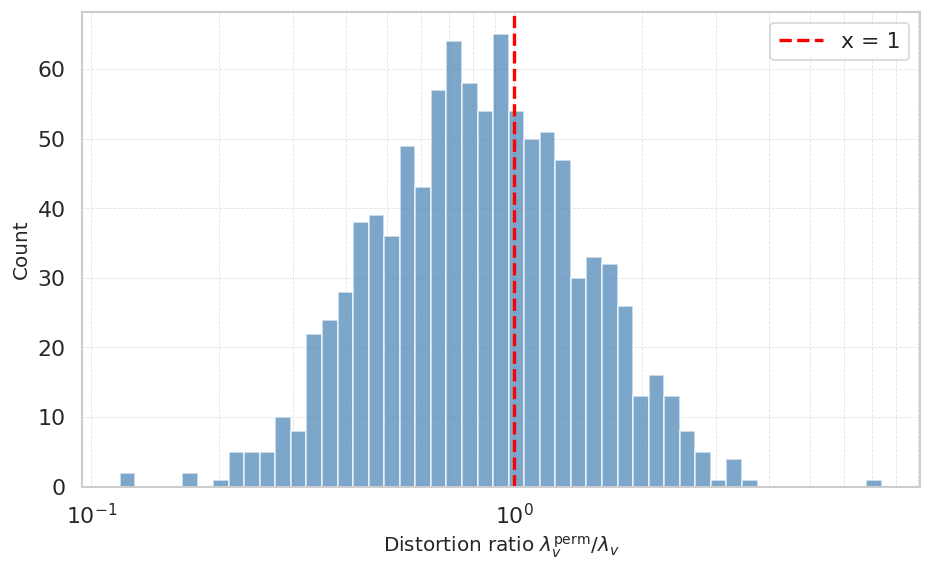

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=120)

# flatten all permutations
x = diag[sort_idxs[:N]]
y = diag_perms[sort_idxs[:N]]

# compute distortion ratio for all M*N values
distortion_ratio = (y / x)

# define log-spaced bins
bins = np.logspace(np.log10(distortion_ratio.min()), np.log10(distortion_ratio.max()), 50)

# histogram with log-spaced bins
ax.hist(
    distortion_ratio,
    bins=bins,
    color="steelblue",
    alpha=0.7,
    edgecolor="white",
    linewidth=1
)

# vertical reference line at 1
ax.axvline(x=1, color='red', linestyle='--', linewidth=2, label='x = 1')

# log scale on x-axis
ax.set_xscale('log')

# labels and title
ax.set_xlabel(r"Distortion ratio $\lambda_v^\mathrm{perm} / \lambda_v$", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

# grid and legend
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)
ax.legend()

plt.tight_layout()
plt.show()

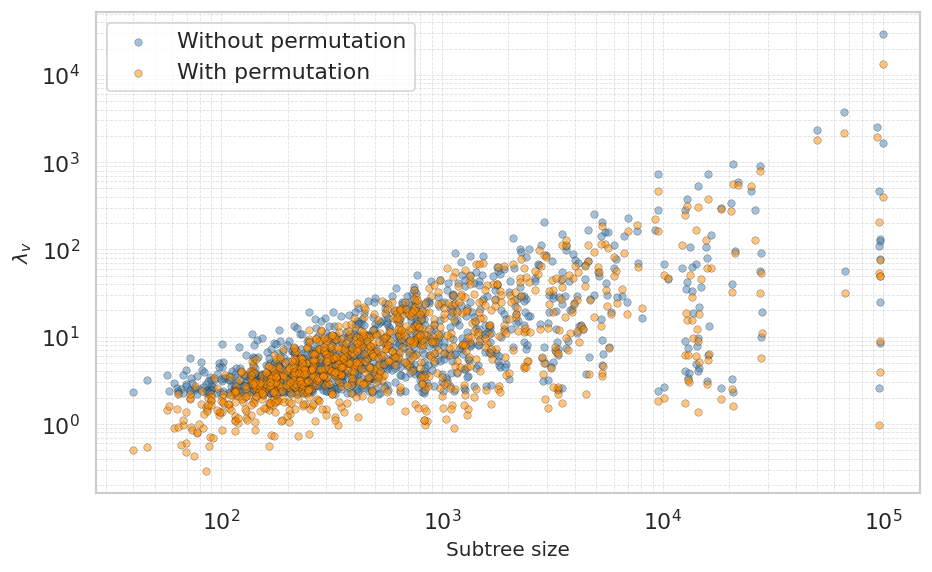

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=120)

x = subtree_sizes[intr_nodes[sort_idxs[:N]]]
y = diag[sort_idxs[:N]]
yy = diag_perms[sort_idxs[:N]]

# scatter points
ax.scatter(
    x, y,
    s=20,
    color="steelblue",
    alpha=0.5,
    edgecolor="k", 
    linewidth=0.3,
    label='Without permutation'
)
ax.scatter(
    x, yy,
    s=20,
    color="darkorange",
    alpha=0.5,
    edgecolor="k", 
    linewidth=0.3,
    label='With permutation'
)

# log scales
ax.set_yscale('log')
ax.set_xscale('log')

# labels and title
ax.set_ylabel(r"$\lambda_v$", fontsize=12)
ax.set_xlabel(r"Subtree size", fontsize=12)

# legend & grid
ax.legend()
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)

plt.tight_layout()
plt.show()

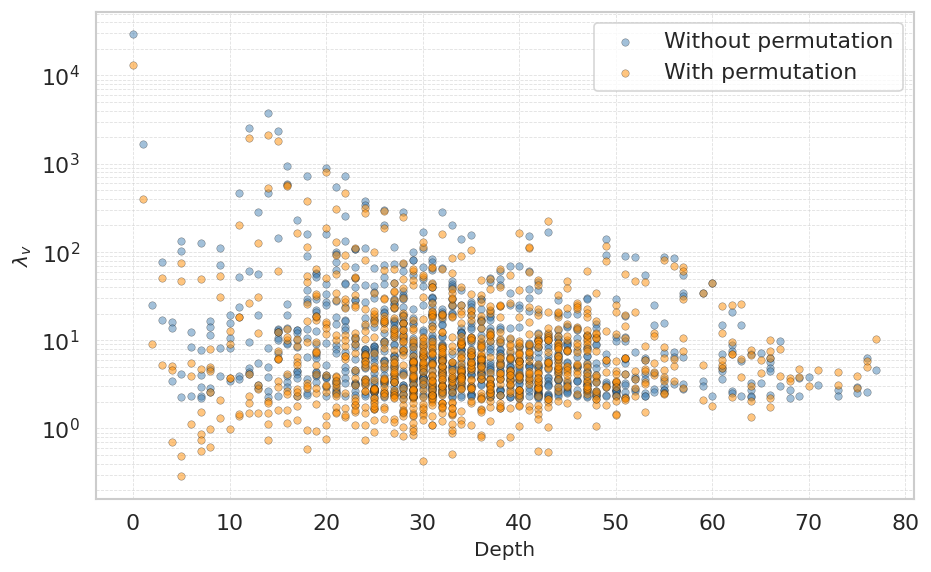

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=120)

x = intr_depths[sort_idxs[:N]]
y = diag[sort_idxs[:N]]
yy = diag_perms[sort_idxs[:N]]

# scatter points
ax.scatter(
    x, y,
    s=20,
    color="steelblue",
    alpha=0.5,
    edgecolor="k", 
    linewidth=0.3,
    label='Without permutation'
)
ax.scatter(
    x, yy,
    s=20,
    color="darkorange",
    alpha=0.5,
    edgecolor="k", 
    linewidth=0.3,
    label='With permutation'
)

# log scales
ax.set_yscale('log')
# ax.set_xscale('log')

# labels and title
ax.set_ylabel(r"$\lambda_v$", fontsize=12)
ax.set_xlabel(r"Depth", fontsize=12)

# legend & grid
ax.legend()
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
intr_nodes, intr_depths = tmp_tree.find_interior_nodes(return_depths=True)
leaves = tmp_tree.find_leaves()
subsets = [intr_nodes, leaves]

dominant_diags = []

M = 50

root = tree.get_child(tree.find_root())
root_idx = np.where(intr_nodes == root)

for i in range(M):
    for subset in subsets:
        perm = np.random.permutation(subset.size)
        for i, node in enumerate(subset):
            tmp_tree.set_edge_length(node, edge_lengths[subset[perm[i]]])
    _, S_perm = pcms.haar.sparsify(tmp_tree)
    diag_perm = S_perm.diagonal()
    dominant_diags.append(diag_perm[root_idx])

dominant_diags = np.array(dominant_diags)

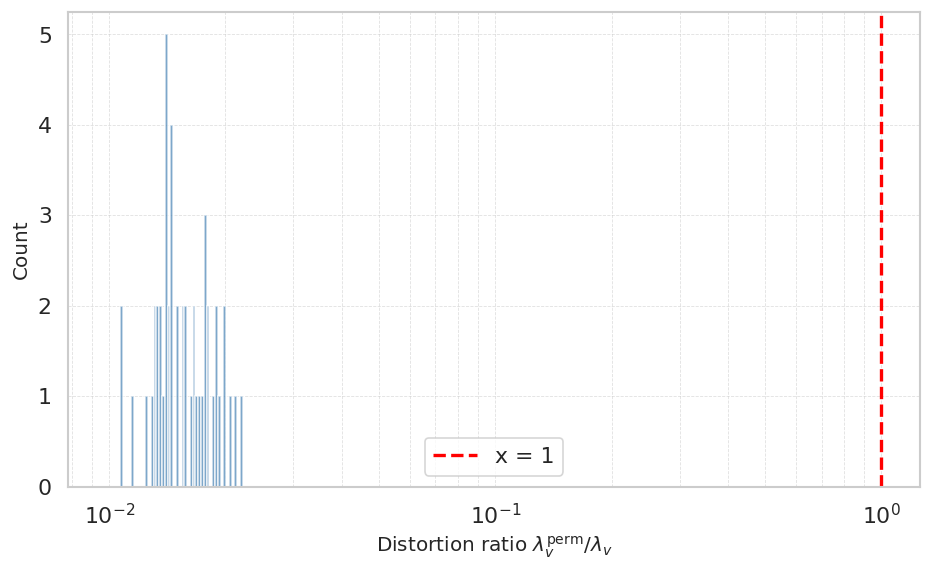

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=120)

# flatten all permutations
x = diag[sort_idxs[0]]
y = dominant_diags

# compute distortion ratio for all M*N values
distortion_ratio = (y / x)

# define log-spaced bins
bins = np.logspace(np.log10(distortion_ratio.min()), np.log10(distortion_ratio.max()), 50)

# histogram with log-spaced bins
ax.hist(
    distortion_ratio,
    bins=bins,
    color="steelblue",
    alpha=0.7,
    edgecolor="white",
    linewidth=1
)

# vertical reference line at 1
ax.axvline(x=1, color='red', linestyle='--', linewidth=2, label='x = 1')

# log scale on x-axis
ax.set_xscale('log')

# labels and title
ax.set_xlabel(r"Distortion ratio $\lambda_v^\mathrm{perm} / \lambda_v$", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

# grid and legend
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)
ax.legend()

plt.tight_layout()
plt.show()

##### How is trace length distributed?

In [ ]:
intr_nodes, intr_depths = tree.find_interior_nodes(return_depths=True)
node = intr_nodes[99310]
trace_lengths = []
leaves, depths = tree.find_leaves(node, return_depths=True)
for leaf in leaves:
    trace_lengths.append(tree.find_tbl(node, leaf))

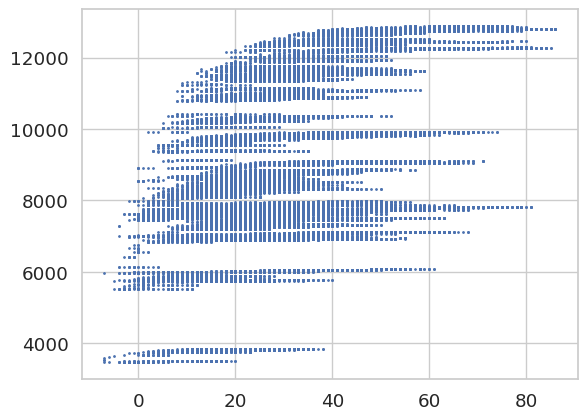

In [ ]:
plt.scatter(depths - intr_depths[99310], trace_lengths, s=1)
plt.show()

In [ ]:
trace_lengths = []
intr_nodes, intr_depths = tree.find_interior_nodes(return_depths=True)
for node in intr_nodes:
    leaves, depths = tree.find_leaves(node, return_depths=True)
    trace_lengths_ = []
    for leaf in leaves:
        trace_lengths_.append(tree.find_tbl(node, leaf))
    trace_lengths_ = np.array(trace_lengths_)
    trace_lengths.append(trace_lengths_)
trace_lengths = np.array(trace_lengths, dtype=object)

In [ ]:
trace_length_means = np.array([np.mean(t) for t in trace_lengths])

/tmp/ipykernel_4478/811744407.py:26: RuntimeWarning: divide by zero encountered in power
  y_pred = np.exp(intercept) * x**slope


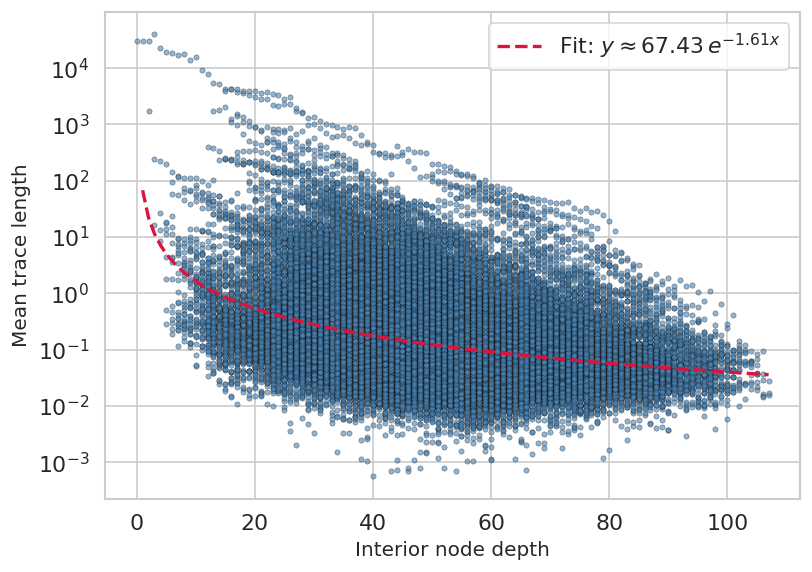

In [ ]:
# Scatter plot
fig, ax = plt.subplots(figsize=(7, 5), dpi=120)

ax.scatter(
    intr_depths,
    trace_length_means,
    s=10,
    color="steelblue",
    alpha=0.6,
    edgecolor="k",
    linewidth=0.3
)

# Log scale on y-axis (semi-log plot)
ax.set_yscale('log')

# Fit exponential model: log(y) ~ a + b*log(x)
x = intr_depths
y = trace_length_means

mask = (x > 0) & (y > 0)  # avoid invalid values
x_fit = np.log(x[mask])
y_fit = np.log(y[mask])

slope, intercept = np.polyfit(x_fit, y_fit, 1)
y_pred = np.exp(intercept) * x**slope

# Sort for smooth line
order = np.argsort(x)
ax.plot(
    x[order],
    y_pred[order],
    color="crimson",
    linewidth=2,
    linestyle='--',
    label=fr"Fit: $y \approx {np.exp(intercept):.2f} \, e^{{{slope:.2f}x}}$"
)

# Labels and legend
ax.set_xlabel("Interior node depth", fontsize=12)
ax.set_ylabel("Mean trace length", fontsize=12)
ax.legend()

plt.tight_layout()
plt.show()

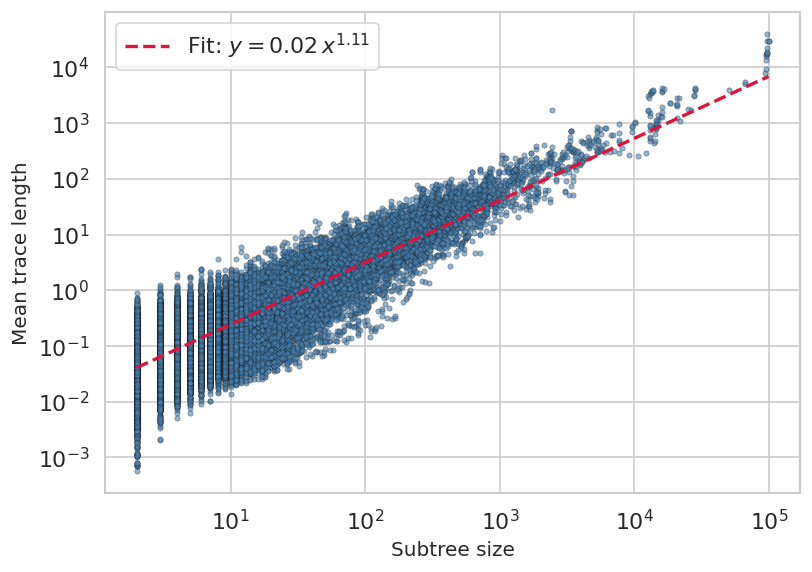

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=120)

x = subtree_sizes[intr_nodes]
y = trace_length_means

# Scatter plot
ax.scatter(
    x, y,
    s=10,
    color="steelblue",
    alpha=0.6,
    edgecolor="k",
    linewidth=0.3
)

# Apply log scales
ax.set_xscale('log')
ax.set_yscale('log')

# Best fit line in log-log space
mask = (x > 0) & (y > 0)
x_fit = np.log(x[mask])
y_fit = np.log(y[mask])

slope, intercept = np.polyfit(x_fit, y_fit, 1)
y_pred = np.exp(intercept) * x**slope

y_pred_sort_idx = np.argsort(y_pred)

ax.plot(
    x[y_pred_sort_idx],
    y_pred[y_pred_sort_idx],
    color="crimson",
    linewidth=2,
    linestyle='--',
    label=fr"Fit: $y = {np.exp(intercept):.2f} \, x^{{{slope:.2f}}}$"
)

# Labels and legend
ax.set_xlabel("Subtree size", fontsize=12)
ax.set_ylabel("Mean trace length", fontsize=12)
ax.legend()

plt.tight_layout()
plt.show()

##### What is the relationship between edge-depth and time-depth

In [ ]:
edge_lengths = tree.get_edge_length()
leaves, leaf_depths = tree.find_leaves(return_depths=True)
intr_nodes, intr_node_depths = tree.find_interior_nodes(return_depths=True)
nodes = np.concatenate([leaves, intr_nodes])
depths = np.concatenate([leaf_depths, intr_node_depths])
sort_idx = np.argsort(nodes)
nodes = nodes[sort_idx]
depths = depths[sort_idx]
time_depths = np.zeros(nodes.size)
for n in nodes:
    if time_depths[n] != 0:
        continue
    ancestors = tree.find_ancestors(n)
    lineage = np.concatenate([[n], ancestors])[::-1]
    cumsum = np.cumsum(edge_lengths[lineage])
    for i, m in enumerate(lineage):
        time_depths[m] = cumsum[i]

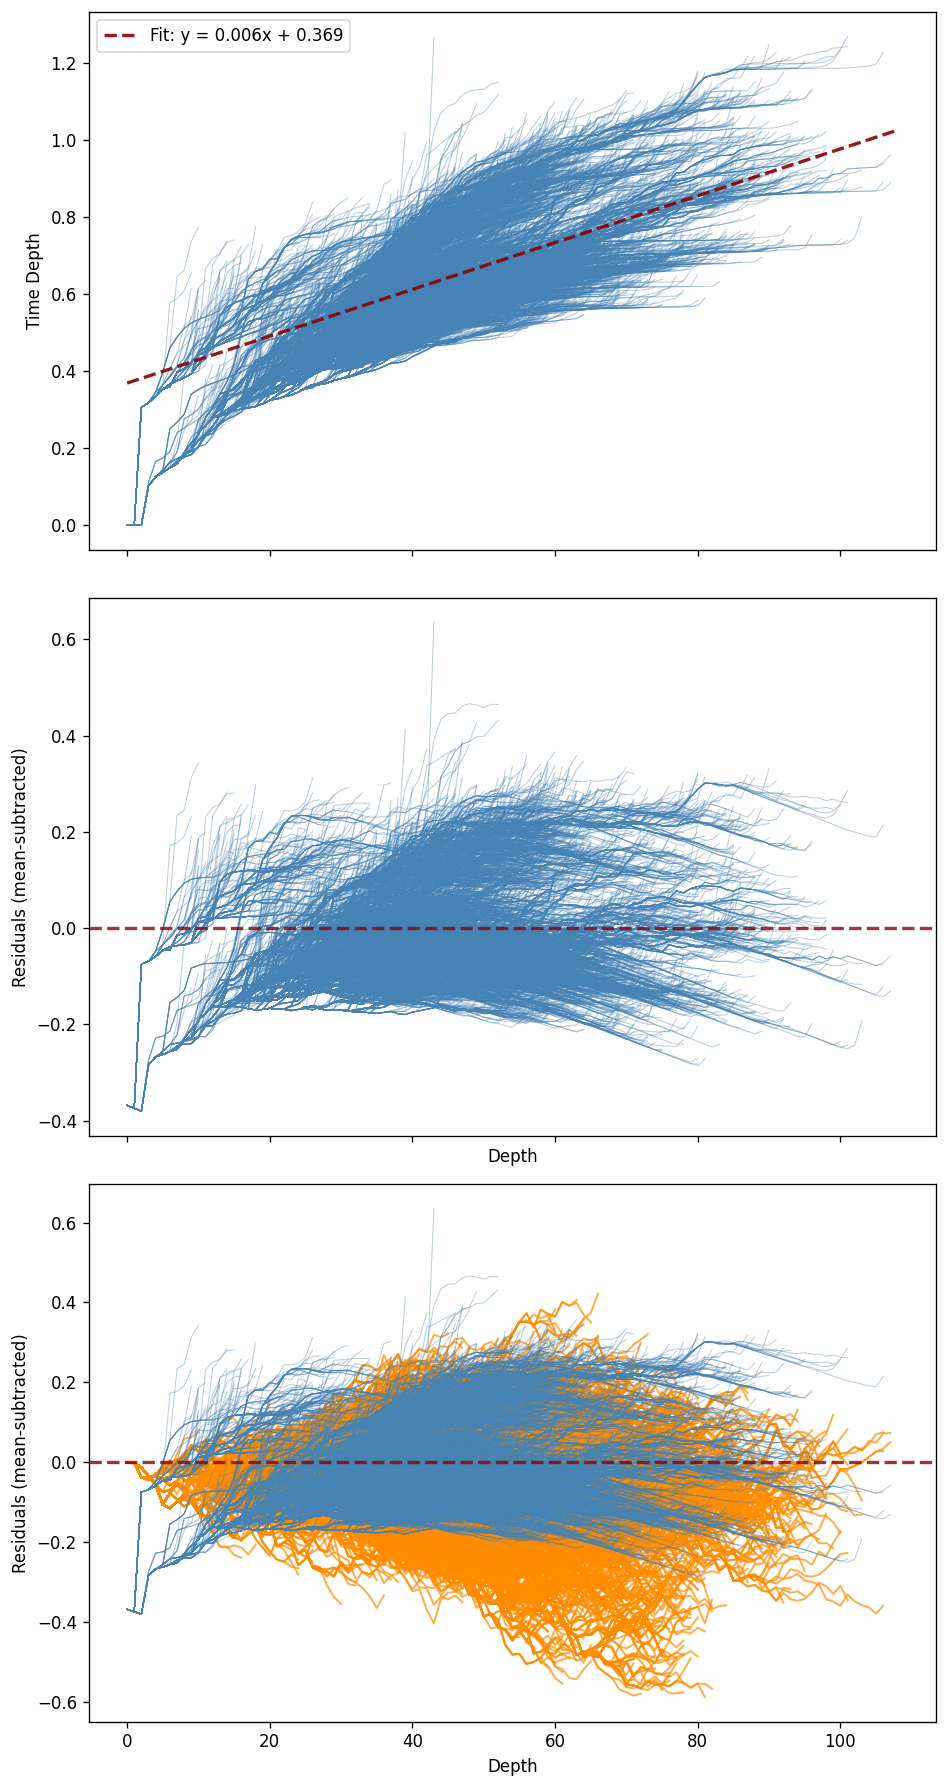

In [ ]:
N = 10000       # number of leaves sampled
k = 2           # envelope width in sigma
M = 10000       # number of BBM sample paths

sampled_leaves = np.random.choice(leaves, size=N, replace=False)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 15), dpi=120, sharex=True)

all_x = []
all_y = []

# --- Collect real lineage paths ---
for n in sampled_leaves:
    anc = tree.find_ancestors(n)
    lineage = np.concatenate([[n], anc])[::-1]
    x = depths[lineage].astype(float)
    y = time_depths[lineage].astype(float)
    ax1.plot(x, y, lw=0.6, alpha=0.4, color="steelblue")
    all_x.append(x)
    all_y.append(y)

all_x_flat = np.concatenate(all_x)
all_y_flat = np.concatenate(all_y)

# --- Plot minimum edge length line ---
m, b = np.polyfit(depths, time_depths, 1)
x_fit = np.linspace(depths.min(), depths.max(), 1000)
fit_vals = m * x_fit + b
ax1.plot(x_fit, fit_vals, lw=2.0, color="darkred", linestyle='--', alpha=0.9,
         label=f'Fit: y = {m:.3f}x {"+" if b >= 0 else "-"} {np.abs(b):.3f}')

# # --- Compute mean per depth bin ---
# n_bins = 100
# depth_min = all_x_flat.min()
# depth_max = all_x_flat.max()
# bins = np.linspace(depth_min, depth_max, n_bins + 1)
# bin_centers = (bins[:-1] + bins[1:]) / 2
# mean_per_bin = []

# for i in range(n_bins):
#     bin_mask = (all_x_flat >= bins[i]) & (all_x_flat < bins[i+1])
#     if np.any(bin_mask):
#         mean_per_bin.append(np.mean(all_y_flat[bin_mask]))
#     else:
#         mean_per_bin.append(np.nan)

# mean_per_bin = np.array(mean_per_bin)

# --- Estimate constant diffusion σ using branch increments ---
dY = []
dX = []
for node in range(tree.n_nodes):
    for child in tree.find_children(node):
        if child == -1:  # skip invalid
            continue
        delta_depth = depths[child] - depths[node]
        delta_time = time_depths[child] - time_depths[node]
        dX.append(delta_depth)
        dY.append(delta_time)

dX = np.array(dX)
dY = np.array(dY)
sigma_hat = np.sqrt(np.sum(dY**2) / np.sum(dX))

# # --- Envelopes for first plot ---
# envelope_upper = mean_per_bin + k*sigma_hat*np.sqrt(bin_centers - depth_min)
# envelope_lower = mean_per_bin - k*sigma_hat*np.sqrt(bin_centers - depth_min)
# ax1.plot(bin_centers, mean_per_bin, lw=2.0, color="darkred", linestyle='--', alpha=0.9)
# ax1.fill_between(bin_centers, envelope_lower, envelope_upper, color="red", alpha=0.2,
#                  label=rf"$\pm {k}\sigma$, $\sigma={sigma_hat:.3g}$")

ax1.set_ylabel("Time Depth")
ax1.legend()

# --- Simulate BBM along tree for second plot ---
def simulate_BBM_paths(tree, depths, sigma, M=1):
    Y_paths = []
    for _ in range(M):
        Y = {}
        def propagate(node):
            parent = tree.get_parent(node)
            if parent == -1:
                Y[node] = 0.0
            else:
                delta_depth = depths[node] - depths[parent]
                Y[node] = Y[parent] + np.random.normal(scale=sigma*np.sqrt(delta_depth))
            for child in tree.find_children(node):
                if child != -1:
                    propagate(child)
        propagate(tree.find_root())
        Y_paths.append(Y)
    return Y_paths

Y_sim_paths = simulate_BBM_paths(tree, depths, sigma_hat)

# Plot simulated BBM paths on second plot
for Y in Y_sim_paths:
    for leaf in np.random.choice(sampled_leaves, size=M, replace=False):
        anc = tree.find_ancestors(leaf)
        lineage = np.concatenate([[leaf], anc])[::-1]
        x = depths[lineage]
        y = np.array([Y[node] for node in lineage])
        ax3.plot(x, y, lw=1.2, alpha=0.7, color="darkorange")

# --- Residuals for plotting purposes ---
for n in sampled_leaves:
    anc = tree.find_ancestors(n)
    lineage = np.concatenate([[n], anc])[::-1]
    x = depths[lineage].astype(float)
    y = time_depths[lineage].astype(float)
    trend_interp = np.interp(x, x_fit, fit_vals)
    y_resid = y - trend_interp
    ax2.plot(x, y_resid, lw=0.6, alpha=0.4, color="steelblue")
    ax3.plot(x, y_resid, lw=0.6, alpha=0.4, color="steelblue")

ax2.axhline(0, color="darkred", lw=2.0, linestyle="--", alpha=0.8)
ax2.set_xlabel("Depth")
ax2.set_ylabel("Residuals (mean-subtracted)")

ax3.axhline(0, color="darkred", lw=2.0, linestyle="--", alpha=0.8)
ax3.set_xlabel("Depth")
ax3.set_ylabel("Residuals (mean-subtracted)")

plt.tight_layout()
plt.show()